In [1]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [2]:
robot.getJointStates()

{'q': array([ 1.33045266e-03, -7.84460406e-01,  6.76818769e-05, -2.37958381e+00,
         7.84799266e-04,  1.56863708e+00,  7.86143536e-01]),
 'dq': array([-0.00013475,  0.00105851, -0.00021101, -0.00038777, -0.00077862,
        -0.00180898, -0.00184866]),
 'T': array([-2.34774828e-01, -4.27423239e+00, -7.00216651e-01,  2.31195412e+01,
         7.77452826e-01,  2.26132941e+00, -1.05035007e-02])}

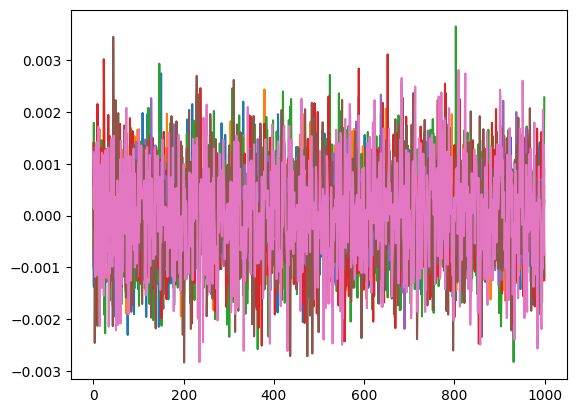

In [21]:
import time
dq_rest_list = []
for i in range(200):
    dq_rest_list.append(robot.getJointStates()['dq'])
    time.sleep(0.01)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(dq_rest_list)


### Preparation

In [3]:
import numpy as np
from FR3Py.robot.model_collision_avoidance import PinocchioModel
import time

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
torque_lb = np.array([-87, -87, -87, -87, -12, -12, -12])
torque_ub = np.array([87, 87, 87, 87, 12, 12, 12])
joint_acc_lb = np.array([-10, -10, -10, -10, -10, -10, -10])
joint_acc_ub = np.array([10, 10, 10, 10, 10, 10, 10])
v_EE_lb = np.array([-0.05, -0.05, -0.05])
v_EE_ub = np.array([0.05, 0.05, 0.05])

n_joints = 7
q_bar = 0.5*(joint_ub + joint_lb)


In [4]:
from cores.utils.bounding_shape_coef_mj import BoundingShapeCoef
from cores.obstacle_collections.polytope_collection import PolytopeCollection
import scalingFunctionsHelperPy as sfh
import HOCBFHelperPy as hh
from scipy.spatial.transform import Rotation
import multiprocessing
from cores.utils.trajectory_utils import PositionTrapezoidalTrajectory, OrientationTrapezoidalTrajectory
from liegroups import SO3
from cores.utils.proxsuite_utils import init_proxsuite_qp
from cores.utils.rotation_utils import get_quat_from_rot_matrix

In [22]:
n_in = 3
n_controls = 7
vel_qp = init_proxsuite_qp(n_v=n_controls, n_eq = 0, n_in=3)

In [24]:
# Rotate link 1 to reach preparation configuration
T = 10
dt = 1.0/150
q_d = np.array([np.pi/3, -np.pi/4, 0, -np.pi/4*3, 0, np.pi/2, np.pi/4])
Kp_joint = np.diag([1, 1, 1, 1, 1, 1, 1])*1e2
Kd_joint = np.diag([2, 2, 2, 2, 2, 2, 2])*1e2

q_list = []
dq_list = []
ddq_list = []
tau_list = []

t_start = time.time()
while time.time() - t_start < T:
    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    M = pin_info["M"][0:n_joints,0:n_joints] + 0.1*np.eye(n_joints) # shape (7,7)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_d)
    deq = W @ dq
    ddq = - Kd_joint @ deq - Kp_joint @ eq
    # u_nominal = M @ (- Kd_joint @ deq - Kp_joint @ eq)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)

    C = np.zeros((n_in, n_controls))
    lb = np.zeros(n_in)
    ub = np.zeros(n_in)

    C[:,:] = J_EE[0:3,:]*dt
    lb[:] = v_EE_lb[:3] - v_EE[:3] - dJdq_EE[:3]*dt
    ub[:] = v_EE_ub[:3] - v_EE[:3] - dJdq_EE[:3]*dt
    g = -ddq

    vel_qp.update(g=g, C=C, l=lb, u=ub)
    vel_qp.solve()
    ddq_safe = vel_qp.results.x
    print(vel_qp.results.info.status)

    u = M @ ddq_safe + nle - G

    # u = M @ ddq + nle - G

    u = np.clip(u, torque_lb, torque_ub)
    robot.setCommands(u)
    # time.sleep(dt)
    q_list.append(q)
    dq_list.append(dq)
    ddq_list.append(ddq_safe)
    tau_list.append(u)

robot.setCommands(np.zeros_like(u))


QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput.PROXQP_SOLVED
QPSolverOutput

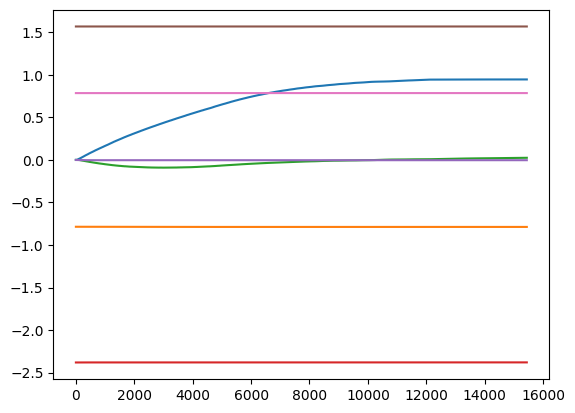

In [25]:
import matplotlib.pyplot as plt

q_list = np.array(q_list)
dq_list = np.array(dq_list)
ddq_list = np.array(ddq_list)
tau_list = np.array(tau_list)

plt.figure()
plt.plot(q_list)

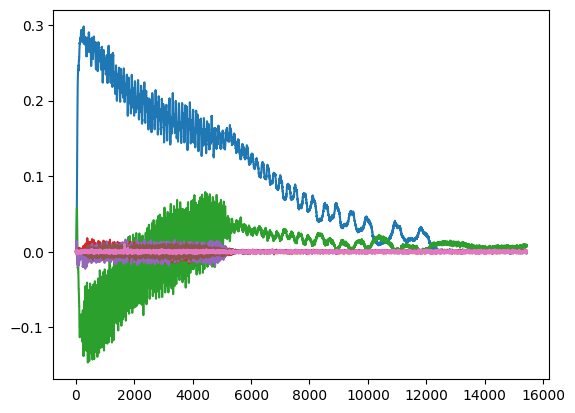

In [26]:
plt.figure()
plt.plot(dq_list)

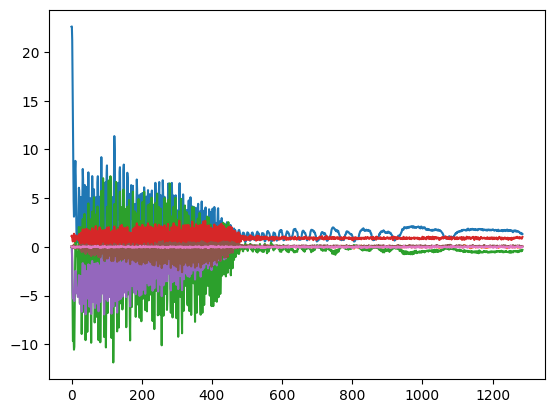

In [10]:
plt.figure()
plt.plot(ddq_list)

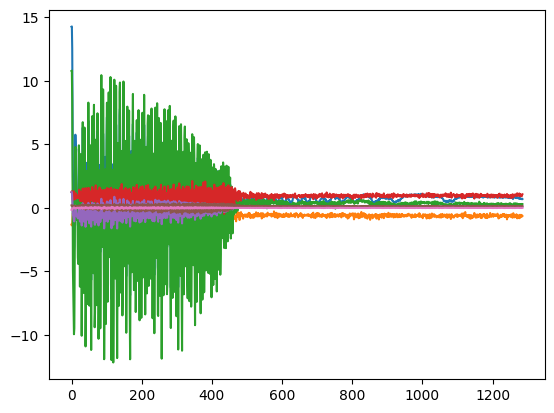

In [11]:
plt.figure()
plt.plot(tau_list)

### Generate the trajectory

In [16]:

robot_info = robot.getJointStates()
q = robot_info['q'] # shape (7,)
dq = robot_info['dq'] # shape (7,)

q_pin = 0.025*np.ones(9)
dq_pin = np.zeros(9)
q_pin[0:n_joints] = q # shape (9,)
dq_pin[0:n_joints] = dq # shape (9,)

pin_info = pin_robot.getInfo(q_pin, dq_pin)
P_EE = pin_info["P_EE"]
R_EE = pin_info["R_EE"]

t_1 = 10
t_2 = 15
t_3 = 25
t_final = 35

# Translational trajectory
P_EE_0 = P_EE.copy()
# P_EE_1 = np.array([0.16, 0.62, 0.04])
P_EE_1 = np.array([0.18, 0.61, 0.10])
# P_EE_2 = np.array([0.45, 0.25, 0.01])
P_EE_2 = np.array([0.50, 0.25, 0.08])

via_points = np.array([P_EE_0, P_EE_1, P_EE_1, P_EE_2, P_EE_2])
# via_points = np.array([P_EE_0, P_EE_0, P_EE_0, P_EE_0])

target_time = np.array([0, t_1, t_2, t_3, t_final])
Ts = 0.01
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=Ts)

# Rotational trajectory
R_EE_0  = R_EE.copy()

roll = np.pi
pitch = 0
yaw = np.pi/3
R_EE_1 = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

roll = np.pi
pitch = 0
yaw = np.pi/6
R_EE_2 = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

orientations = np.array([R_EE_0, R_EE_1, R_EE_1, R_EE_2, R_EE_2])
# orientations = np.array([R_EE_0, R_EE_0, R_EE_0, R_EE_0])
target_time = np.array([0, t_1, t_2, t_3, t_final])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=Ts)